In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data import Dataset
import pandas as pd
from tqdm import tqdm


import matplotlib.pyplot as plt

In [2]:
class Data(Dataset):
    def __init__(self, csv_file, transform=None):

        super(Data, self).__init__()
        file = pd.read_csv(csv_file)
        self.input_data = file['x'].values
        self.labels = file['y'].values.astype(int)   
          
    def __getitem__(self, index):
        data_item = self.input_data[index]
        data_item = torch.tensor(data_item).float().unsqueeze(-1)

        label = self.labels[index]
        return data_item, label

    def __len__(self):
        return len(self.input_data)

In [3]:
train_data = Data('train_q3.csv')
test_data = Data('test_q3.csv')
batch_size = 256
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
           nn.Linear(1, 4),
           nn.ReLU(),
           nn.Linear(4, 1),
           nn.Sigmoid()
        )
        self.initialize_weights()

        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                     nn.init.zeros_(m.bias)  

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)

In [6]:
# tune training rate 
learning_rate = 0.1


In [7]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
model.train()
epoches = 150
losses = np.zeros(epoches)
for epoch in tqdm(range(epoches)):
    train_loss, correct = 0, 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device).unsqueeze(-1)


        pred = model(X)

        loss = loss_fn(pred, y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record loss
        train_loss += loss.item()
        correct += (torch.where(pred > 0.5, 1, 0) == y).sum().item()
    size = len(train_dataloader.dataset)
    train_loss /= len(train_dataloader)
    correct /= size
    losses[epoch] = train_loss
    if epoch % 10 == 0:
        print(f" Train accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")

  1%|          | 1/150 [00:01<04:04,  1.64s/it]

 Train accuracy: 97.5%, Avg loss: 0.384442


  7%|▋         | 11/150 [00:05<01:03,  2.18it/s]

 Train accuracy: 99.8%, Avg loss: 0.099509


 14%|█▍        | 21/150 [00:08<00:42,  3.05it/s]

 Train accuracy: 99.8%, Avg loss: 0.069507


 21%|██        | 31/150 [00:11<00:34,  3.42it/s]

 Train accuracy: 99.9%, Avg loss: 0.056486


 27%|██▋       | 41/150 [00:15<00:36,  2.98it/s]

 Train accuracy: 99.9%, Avg loss: 0.048810


 34%|███▍      | 51/150 [00:18<00:29,  3.30it/s]

 Train accuracy: 99.9%, Avg loss: 0.043613


 41%|████      | 61/150 [00:21<00:24,  3.62it/s]

 Train accuracy: 99.9%, Avg loss: 0.039801


 47%|████▋     | 71/150 [00:24<00:26,  2.97it/s]

 Train accuracy: 99.9%, Avg loss: 0.036854


 54%|█████▍    | 81/150 [00:27<00:18,  3.74it/s]

 Train accuracy: 99.9%, Avg loss: 0.034491


 61%|██████    | 91/150 [00:30<00:18,  3.15it/s]

 Train accuracy: 99.9%, Avg loss: 0.032542


 67%|██████▋   | 101/150 [00:33<00:15,  3.18it/s]

 Train accuracy: 99.9%, Avg loss: 0.030899


 74%|███████▍  | 111/150 [00:37<00:11,  3.54it/s]

 Train accuracy: 99.9%, Avg loss: 0.029491


 81%|████████  | 121/150 [00:40<00:09,  3.01it/s]

 Train accuracy: 100.0%, Avg loss: 0.028267


 87%|████████▋ | 131/150 [00:43<00:05,  3.68it/s]

 Train accuracy: 100.0%, Avg loss: 0.027190


 94%|█████████▍| 141/150 [00:47<00:02,  3.10it/s]

 Train accuracy: 100.0%, Avg loss: 0.026233


100%|██████████| 150/150 [00:50<00:00,  2.99it/s]


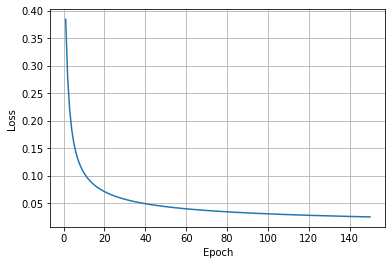

In [9]:
plt.plot(range(1, epoches + 1), losses, label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [10]:
print(f'W1 = {model.linear_relu_stack[0].weight}')
print(f'W2 = {model.linear_relu_stack[2].weight}')

W1 = Parameter containing:
tensor([[ 3.4906],
        [-3.4718],
        [ 5.8911],
        [ 2.2419]], requires_grad=True)
W2 = Parameter containing:
tensor([[ 3.5390, -3.8231,  5.5510,  2.0458]], requires_grad=True)


In [11]:
model.eval()
correct = 0
# Turn off gradient descent
with torch.no_grad():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device).unsqueeze(-1)
        pred = model(X)
        correct += (torch.where(pred > 0.5, 1, 0) == y).sum().item()
size = len(test_dataloader.dataset)
correct = correct / size
print(f" Test accuracy: {(100*correct):>0.1f}%")

100%|██████████| 8/8 [00:00<00:00, 160.10it/s]

 Test accuracy: 100.0%
